# LastFM Recommender Genre Topic Modeling: TF-IDF + NMF
July [X], 2018

In [1]:
import sys
sys.executable

'/Users/brianmcmahon/anaconda3/envs/recommender/bin/python'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from os import path, getcwd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from PIL import Image

import gensim
from gensim import matutils, models

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

CWD = '/Volumes/BC_Clutch/Dropbox/recommender_system/'

In [3]:
# sets output to three decimals
pd.set_option('display.float_format',lambda x: '%.3f' %x)

In [4]:
tag_data = pd.read_csv('../data/recsys_tags2.csv')
tag_data = tag_data.set_index(['idx'])
tag_data['tags'] = tag_data['tags'].apply(lambda x: ', '.join(x.split('|')))
tag_data.head()

,name,tags
idx,,
0,3 Doors Down,"00s, 2008, 90s, acoustic, acoustic rock, alter..."
1,30 Seconds to Mars,"00s, <3, acoustic, addictive, alternative, alt..."
2,3OH!3,"00s, 10s, 2007, 2008, 2009, 2010, <3, addictiv..."
3,50 Cent,"00s, american, awesome, catchy, club, dance, g..."
4,A Day to Remember,"<3, acoustic, alternative, american, christian..."


In [5]:
tag_data.tags[0]

'00s, 2008, 90s, acoustic, acoustic rock, alternative, alternative rock, american, awesome, cute, grunge, guilty pleasure, hard rock, love, male vocalists, melancholic, other great tracks, pop, pop rock, post-grunge, prejebeno, punk, rock, romantic, soft rock, soundtrack'

In [6]:
tag_data.shape

(505, 2)

### Assumptions

In [7]:
data = tag_data.tags
n_topics = 6
seed = 42
ngram_range = (1,3)
ncols = 2

sw = set(STOPWORDS)

adds = ['rock','pop','hardcore','vocalist','male','female']
for word in adds:
    sw.add(word)


### TF-IDF / NMF

In [54]:
data = tag_data.tags
model_list = ['LDA','NMF-FN','NMF-KL']
class_list = ['all']
# ngram_range = (2,3)
max_iter = 100000
max_df = .01
min_df = 1
# n_components = 6 
n_features = 1000
n_top_words = 50
ncols = 2

In [55]:
def print_top_words(model, feature_names, n_top_words):
    listy = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        listy.append(message)
    return listy  

saved at ../charts/tfidfnmflda_wcallNMF-FN
saved at ../charts/tfidfnmflda_wcallNMF-KL
saved at ../charts/tfidfnmflda_wcallLDA


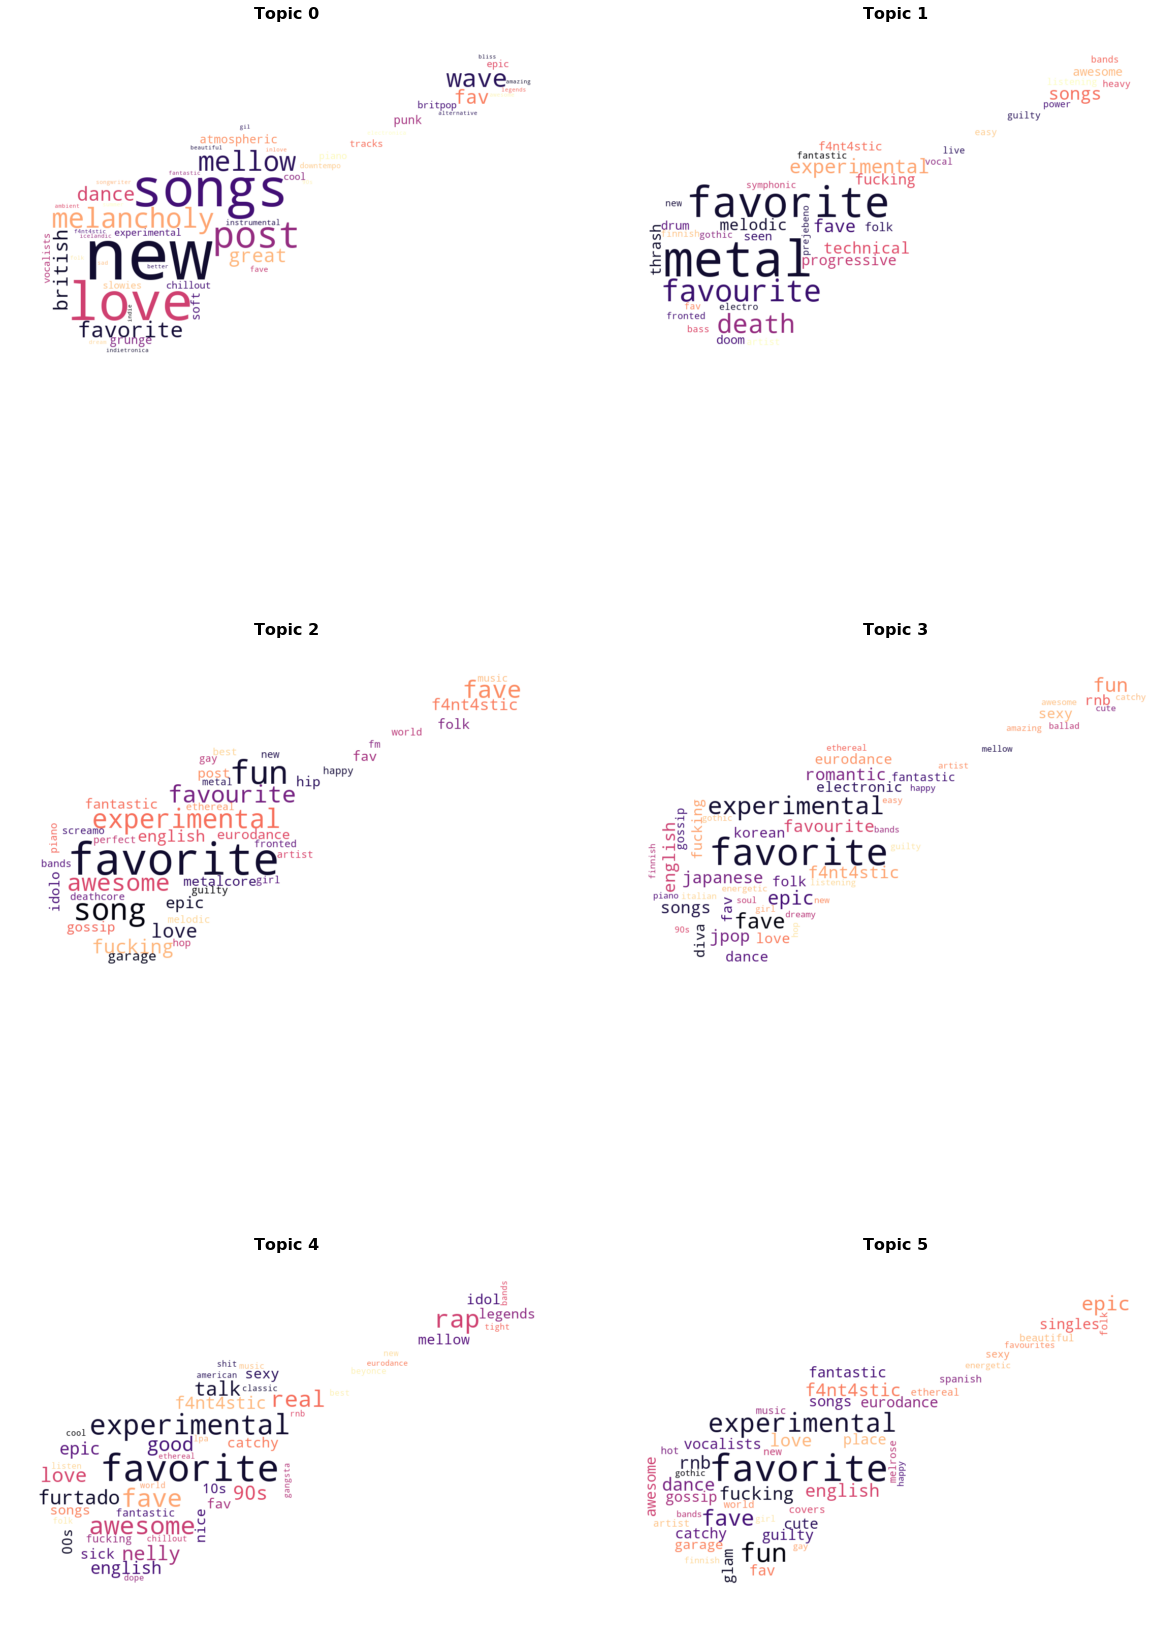

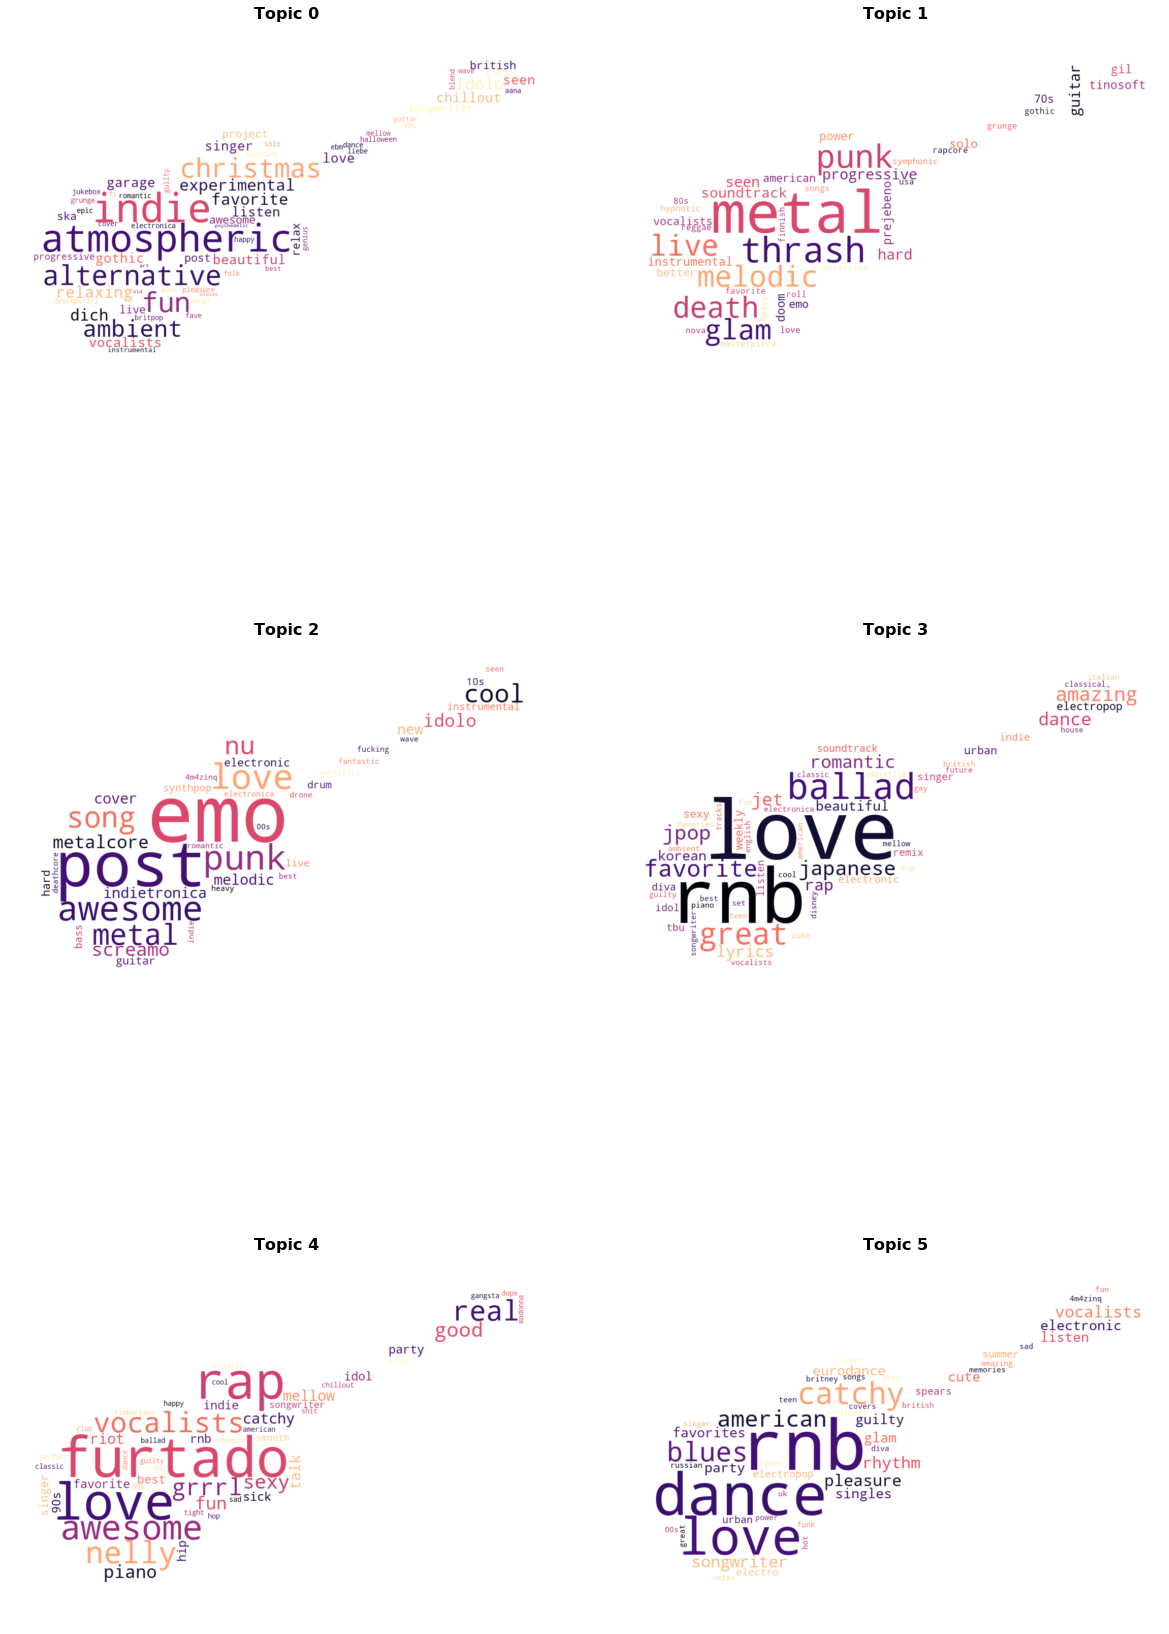

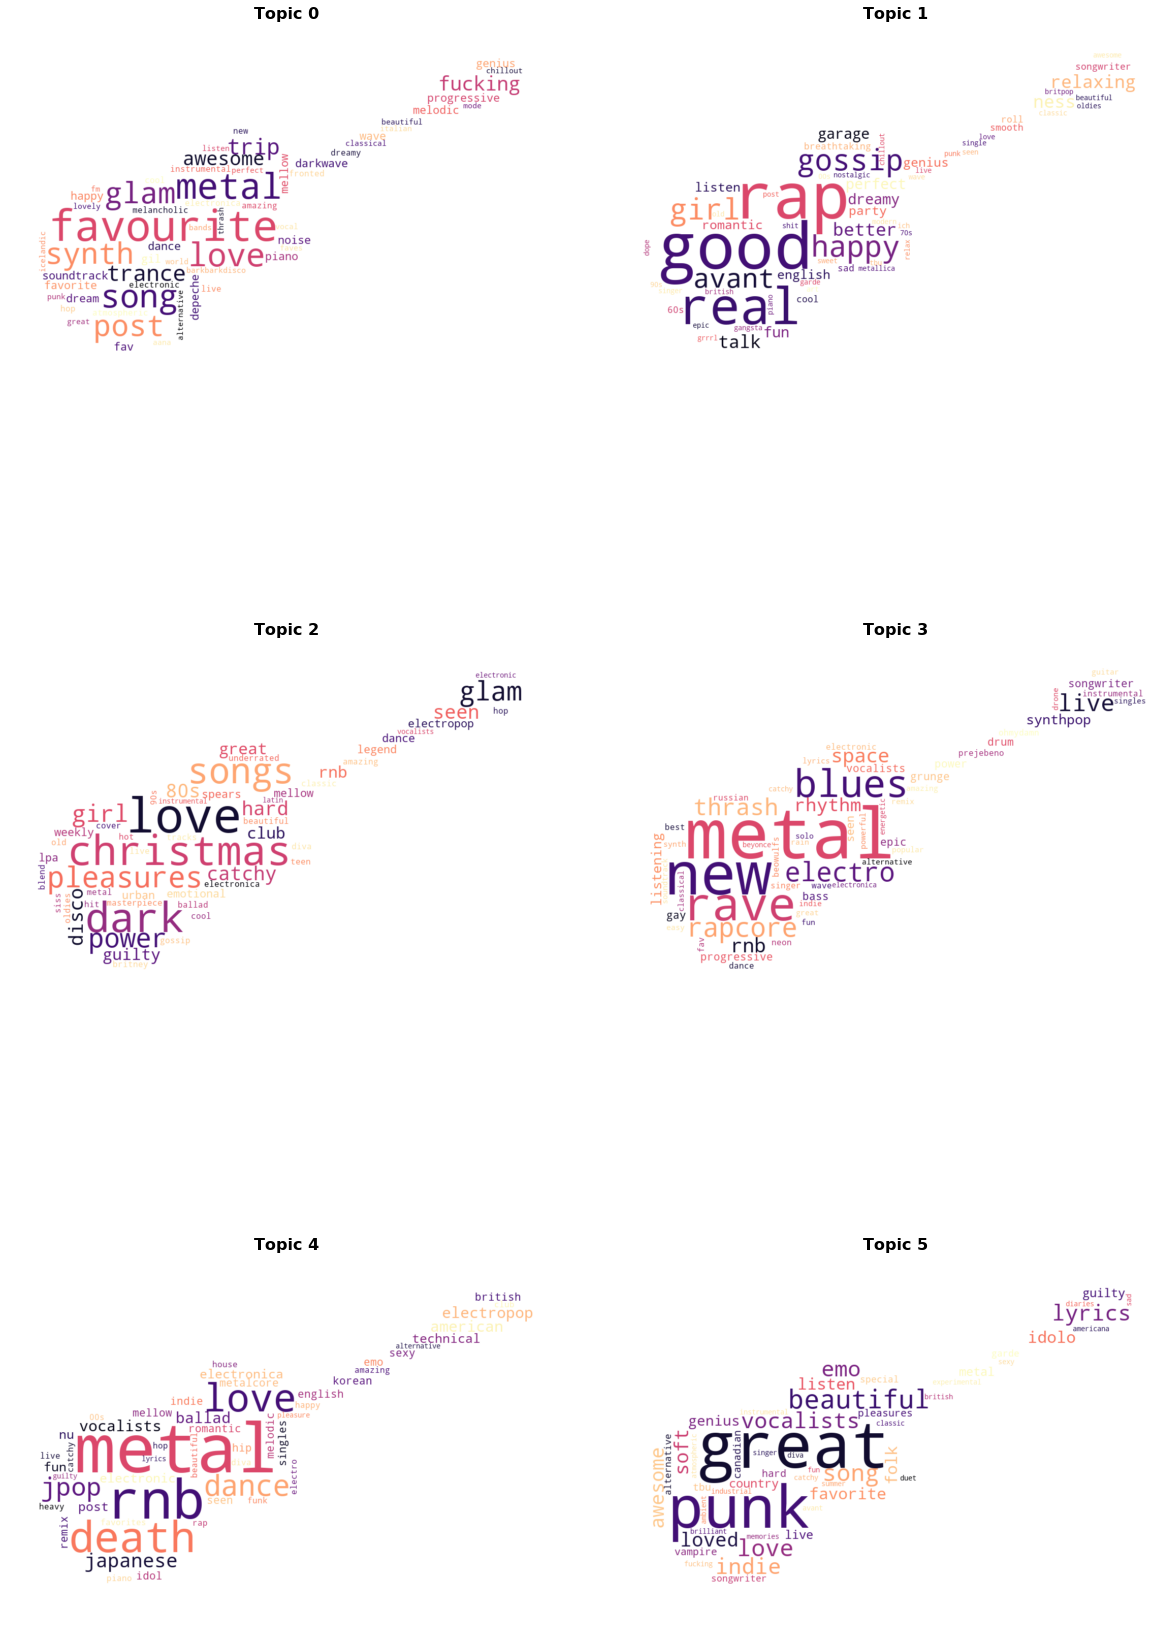

In [56]:
class_tfidfnmf = {}
for item in class_list:
#     if item == 'all':
#         data = tag_data.tags
#     else:
#         data = dataset[dataset[item]==1]

    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range,
                                       max_df=max_df, 
                                       min_df=min_df,
                                       max_features=n_features,
                                       stop_words='english')
    
    tfidf = tfidf_vectorizer.fit_transform(data)

    tf_vectorizer = CountVectorizer(ngram_range=ngram_range,
                                    max_df=max_df, 
                                    min_df=min_df,
                                    max_features=n_features,
                                    stop_words='english')
    
    tf = tf_vectorizer.fit_transform(data)

    nmf = NMF(n_components=n_topics, 
              random_state=seed,
              alpha=.1, 
              l1_ratio=.5).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    aa = print_top_words(nmf, 
                         tfidf_feature_names, 
                         n_top_words)

    nmf = NMF(n_components=n_topics, 
              random_state=seed,
              beta_loss='kullback-leibler', 
              solver='mu', 
              max_iter=max_iter, 
              alpha=.1,
              l1_ratio=.5).fit(tfidf)

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    bb = print_top_words(nmf, 
                         tfidf_feature_names, 
                         n_top_words)

    lda = LatentDirichletAllocation(n_components=n_topics, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=seed)
    lda.fit(tf)

    tf_feature_names = tf_vectorizer.get_feature_names()

    cc = print_top_words(lda, 
                         tf_feature_names, 
                         n_top_words)
    
    class_tfidfnmf[item] = {'NMF-FN':aa, 'NMF-KL':bb, 'LDA':cc}
    
    # plot wordclouds
    for e in class_tfidfnmf[item]:
        fig = plt.figure(figsize=(20,100))
        chart_tot = n_topics * len(class_list) * len(model_list)
        ncols = ncols
        nrows = math.ceil(chart_tot / ncols)
        for i in range(n_topics):
            ax = fig.add_subplot(nrows,ncols,i+1)
            text = ' '.join(class_tfidfnmf[item][e][i].split()[2:])
            title = "Topic: " + str(item) + "_" + str(e) + "_" + "_" + str(i)
            
            generate_wordcloud(text)
            
        filepath = '../charts/tfidfnmflda_wc' + str(item) + str(e)
        plt.savefig(filepath)
        print('saved at ' + filepath)